In [1]:
to_plot = True

In [26]:
#Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import copy
import itertools

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.metrics import Metric

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as mtr

In [3]:
#Custom Imports
sys.path.append('../src')
import ml_functions as ml
import neural_network as nn

In [4]:
#Loading Data
df = pd.read_csv('../data/training_set_(50_50).csv', index_col = 0)
df_test = pd.read_csv('../data/testing_set_(90_10).csv', index_col = 0)

In [5]:
#Combining All Data
df_all = pd.concat([df, df_test])

In [6]:
#Dropping unnecessary columns
to_drop = ['account_creation_time','account_active_duration','time_between_first_and_last_transaction',
           'gini_coefficient_accounts_received','gini_coefficient_accounts_sent',
           'gini_coefficient_values_received','gini_coefficient_values_sent']

In [7]:
#All Data Drop
df_all.drop(to_drop, axis = 1, inplace = True)

In [8]:
#Data Shuffle
df_all = df_all.sample(frac = 1, random_state = 2022)

In [9]:
#Constructing Test Set
test_n = 5000
test_ponzi_frac = 0.1

df_test = pd.concat([df_all.loc[df_all.ponzi].iloc[:int(test_n*test_ponzi_frac)],
                     df_all.loc[~df_all.ponzi].iloc[:int(test_n*(1-test_ponzi_frac))]])

x_test = df_test.iloc[:,:-1]
y_test = df_test.ponzi.astype(int)

In [10]:
#Constructing Train Set
mask = [x for x in df_all.index if x not in df_test.index]

x_train_base = df_all.loc[mask].iloc[:,:-1]
y_train_base = df_all.ponzi.loc[mask].astype(int)

validation_frac = 0.2
validation_index = int(len(x_train_base)*(1-validation_frac))+1

x_train = x_train_base.iloc[:validation_index,:]
y_train = y_train_base[:validation_index]

x_val = x_train_base.iloc[validation_index:,:]
y_val = y_train_base[validation_index:]

In [11]:
#Scaling Train Data
scaler = PowerTransformer()
#scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_train = tf.convert_to_tensor(x_train, dtype = tf.float64)
y_train = tf.convert_to_tensor(y_train, dtype = tf.float64)

In [12]:
#Scaling Validation Data
x_val = tf.convert_to_tensor(scaler.transform(x_val), dtype = tf.float64)
y_val = tf.convert_to_tensor(y_val, dtype = tf.float64)

In [13]:
#Scaling Test Data
x_test = tf.convert_to_tensor(scaler.transform(x_test), dtype = tf.float64)
y_test = tf.convert_to_tensor(y_test, dtype = tf.float64)

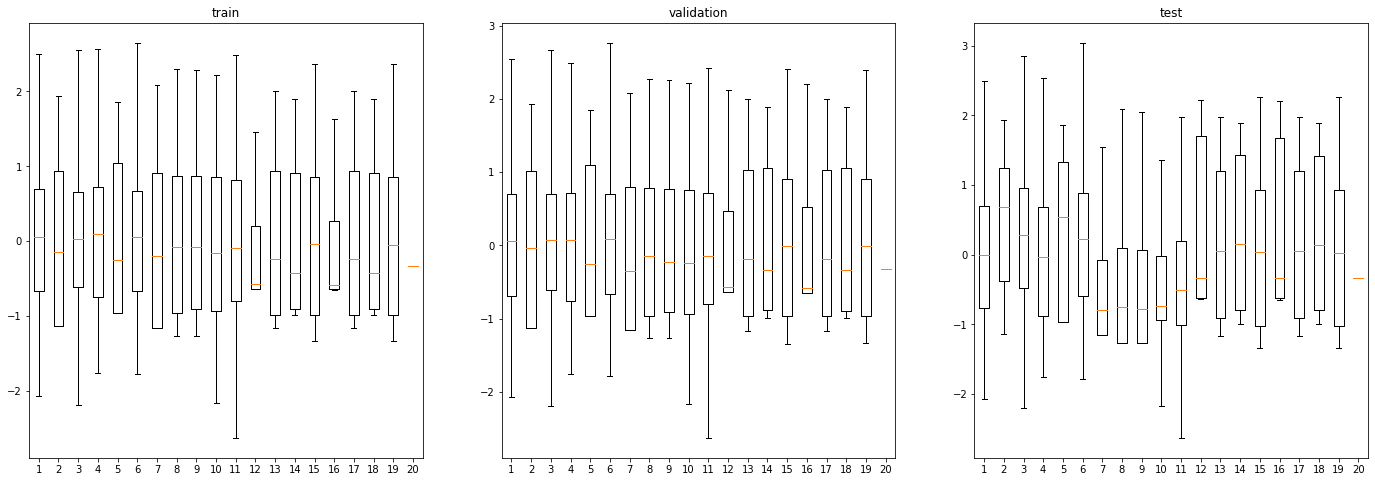

In [14]:
#Plotting Scaled Data
if to_plot:
    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
    ax[0].boxplot(x_train.numpy(), showfliers = False)
    ax[0].set_title('train')
    ax[1].boxplot(x_val.numpy(), showfliers = False)
    ax[1].set_title('validation')
    ax[2].boxplot(x_test.numpy(), showfliers = False)
    ax[2].set_title('test')
    plt.show()

In [15]:
#Specifying NN Hyperparameters
#Design
layer_types = ['dense', 'dropout'] * 4

n_nodes_per_layer = 512

n_nodes = [n_nodes_per_layer if x == 'dense' else None for x in layer_types]
activations = [tf.nn.leaky_relu if x == 'dense' else None for x in layer_types]
dropout_param = 0.25
optimiser = tf.keras.optimizers.Adam
loss_fn = tf.losses.BinaryCrossentropy()
start_learn_rate = 1E-4


callback_es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 100, verbose = 1)
callback_rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.5, patience = 20,
                                                    min_delta = 1E-4, cooldown = 20, min_lr = 1E-6, verbose = 1)

#Training
n_epochs = 1000
batch_size = 32

In [16]:
#Creating NNs
nn7 = nn.NeuralNetwork(x_train, y_train, x_val, y_val,
                       layer_types, n_nodes, activations, dropout_param, optimiser, loss_fn, start_learn_rate,
                       filepath = r'C:\Users\quekh\Desktop\temp\nn7', long_folder = False)

In [17]:
#Training
nn7.model_fit(batch_size, n_epochs, callback_list = [callback_es, callback_rlr], save_checkpoints = True)

Epoch 1/1000
1042/1042 [==============================] - ETA: 0s - loss: 0.3951 - binary_accuracy: 0.8261 - precision: 0.8388 - recall: 0.8158 - F1: 0.8272 - F2: 0.8203
Epoch 00001: val_loss improved from inf to 0.35129, saving model to C:\Users\quekh\Desktop\temp\nn7\f1\ckpt\weights.01-0.35
1042/1042 [==============================] - 12s 11ms/step - loss: 0.3951 - binary_accuracy: 0.8261 - precision: 0.8388 - recall: 0.8158 - F1: 0.8272 - F2: 0.8203 - val_loss: 0.3513 - val_binary_accuracy: 0.8543 - val_precision: 0.8394 - val_recall: 0.8446 - val_F1: 0.8420 - val_F2: 0.8436
Epoch 2/1000
1039/1042 [============================>.] - ETA: 0s - loss: 0.3622 - binary_accuracy: 0.8440 - precision: 0.8576 - recall: 0.8323 - F1: 0.8448 - F2: 0.8373
Epoch 00002: val_loss improved from 0.35129 to 0.33298, saving model to C:\Users\quekh\Desktop\temp\nn7\f1\ckpt\weights.02-0.33
1042/1042 [==============================] - 11s 10ms/step - loss: 0.3619 - binary_accuracy: 0.8441 - precision: 0.85

Epoch 16/1000
1037/1042 [============================>.] - ETA: 0s - loss: 0.2932 - binary_accuracy: 0.8769 - precision: 0.8890 - recall: 0.8672 - F1: 0.8779 - F2: 0.8715
Epoch 00016: val_loss improved from 0.28768 to 0.28205, saving model to C:\Users\quekh\Desktop\temp\nn7\f1\ckpt\weights.16-0.28
1042/1042 [==============================] - 11s 11ms/step - loss: 0.2934 - binary_accuracy: 0.8767 - precision: 0.8887 - recall: 0.8669 - F1: 0.8777 - F2: 0.8712 - val_loss: 0.2820 - val_binary_accuracy: 0.8853 - val_precision: 0.8844 - val_recall: 0.8632 - val_F1: 0.8737 - val_F2: 0.8674
Epoch 17/1000
1038/1042 [============================>.] - ETA: 0s - loss: 0.2911 - binary_accuracy: 0.8759 - precision: 0.8868 - recall: 0.8676 - F1: 0.8771 - F2: 0.8714
Epoch 00017: val_loss did not improve from 0.28205
1042/1042 [==============================] - 11s 11ms/step - loss: 0.2912 - binary_accuracy: 0.8758 - precision: 0.8866 - recall: 0.8675 - F1: 0.8770 - F2: 0.8712 - val_loss: 0.2841 - val_

1039/1042 [============================>.] - ETA: 0s - loss: 0.2739 - binary_accuracy: 0.8847 - precision: 0.8970 - recall: 0.8744 - F1: 0.8856 - F2: 0.8788
Epoch 00031: val_loss improved from 0.27561 to 0.27429, saving model to C:\Users\quekh\Desktop\temp\nn7\f1\ckpt\weights.31-0.27
1042/1042 [==============================] - 11s 10ms/step - loss: 0.2740 - binary_accuracy: 0.8846 - precision: 0.8969 - recall: 0.8743 - F1: 0.8854 - F2: 0.8787 - val_loss: 0.2743 - val_binary_accuracy: 0.8926 - val_precision: 0.8919 - val_recall: 0.8721 - val_F1: 0.8818 - val_F2: 0.8760
Epoch 32/1000
1040/1042 [============================>.] - ETA: 0s - loss: 0.2736 - binary_accuracy: 0.8860 - precision: 0.8967 - recall: 0.8775 - F1: 0.8870 - F2: 0.8813
Epoch 00032: val_loss did not improve from 0.27429
1042/1042 [==============================] - 11s 11ms/step - loss: 0.2734 - binary_accuracy: 0.8861 - precision: 0.8969 - recall: 0.8777 - F1: 0.8872 - F2: 0.8814 - val_loss: 0.2775 - val_binary_accurac

1040/1042 [============================>.] - ETA: 0s - loss: 0.2642 - binary_accuracy: 0.8903 - precision: 0.9026 - recall: 0.8800 - F1: 0.8912 - F2: 0.8844
Epoch 00046: val_loss did not improve from 0.26804
1042/1042 [==============================] - 12s 12ms/step - loss: 0.2642 - binary_accuracy: 0.8904 - precision: 0.9026 - recall: 0.8800 - F1: 0.8912 - F2: 0.8844 - val_loss: 0.2702 - val_binary_accuracy: 0.8965 - val_precision: 0.8891 - val_recall: 0.8854 - val_F1: 0.8872 - val_F2: 0.8861
Epoch 47/1000
1041/1042 [============================>.] - ETA: 0s - loss: 0.2643 - binary_accuracy: 0.8901 - precision: 0.9014 - recall: 0.8810 - F1: 0.8910 - F2: 0.8850
Epoch 00047: val_loss improved from 0.26804 to 0.26737, saving model to C:\Users\quekh\Desktop\temp\nn7\f1\ckpt\weights.47-0.27
1042/1042 [==============================] - 12s 11ms/step - loss: 0.2643 - binary_accuracy: 0.8901 - precision: 0.9014 - recall: 0.8810 - F1: 0.8910 - F2: 0.8850 - val_loss: 0.2674 - val_binary_accurac

Epoch 62/1000
1039/1042 [============================>.] - ETA: 0s - loss: 0.2535 - binary_accuracy: 0.8952 - precision: 0.9046 - recall: 0.8881 - F1: 0.8963 - F2: 0.8914
Epoch 00062: val_loss did not improve from 0.26487
1042/1042 [==============================] - 12s 12ms/step - loss: 0.2534 - binary_accuracy: 0.8952 - precision: 0.9047 - recall: 0.8882 - F1: 0.8964 - F2: 0.8914 - val_loss: 0.2679 - val_binary_accuracy: 0.8949 - val_precision: 0.8943 - val_recall: 0.8747 - val_F1: 0.8844 - val_F2: 0.8785
Epoch 63/1000
1042/1042 [==============================] - ETA: 0s - loss: 0.2545 - binary_accuracy: 0.8957 - precision: 0.9065 - recall: 0.8869 - F1: 0.8966 - F2: 0.8908
Epoch 00063: val_loss improved from 0.26487 to 0.26373, saving model to C:\Users\quekh\Desktop\temp\nn7\f1\ckpt\weights.63-0.26
1042/1042 [==============================] - 12s 11ms/step - loss: 0.2545 - binary_accuracy: 0.8957 - precision: 0.9065 - recall: 0.8869 - F1: 0.8966 - F2: 0.8908 - val_loss: 0.2637 - val_

Epoch 78/1000
1039/1042 [============================>.] - ETA: 0s - loss: 0.2490 - binary_accuracy: 0.8958 - precision: 0.9080 - recall: 0.8853 - F1: 0.8965 - F2: 0.8898
Epoch 00078: val_loss did not improve from 0.26307
1042/1042 [==============================] - 12s 12ms/step - loss: 0.2490 - binary_accuracy: 0.8957 - precision: 0.9081 - recall: 0.8852 - F1: 0.8965 - F2: 0.8897 - val_loss: 0.2633 - val_binary_accuracy: 0.8982 - val_precision: 0.8926 - val_recall: 0.8851 - val_F1: 0.8888 - val_F2: 0.8866
Epoch 79/1000
1040/1042 [============================>.] - ETA: 0s - loss: 0.2467 - binary_accuracy: 0.8972 - precision: 0.9088 - recall: 0.8875 - F1: 0.8980 - F2: 0.8917
Epoch 00079: val_loss improved from 0.26307 to 0.26191, saving model to C:\Users\quekh\Desktop\temp\nn7\f1\ckpt\weights.79-0.26
1042/1042 [==============================] - 12s 11ms/step - loss: 0.2466 - binary_accuracy: 0.8972 - precision: 0.9087 - recall: 0.8877 - F1: 0.8981 - F2: 0.8918 - val_loss: 0.2619 - val_

Epoch 94/1000
1040/1042 [============================>.] - ETA: 0s - loss: 0.2426 - binary_accuracy: 0.8993 - precision: 0.9105 - recall: 0.8902 - F1: 0.9002 - F2: 0.8942
Epoch 00094: val_loss did not improve from 0.25965
1042/1042 [==============================] - 11s 11ms/step - loss: 0.2427 - binary_accuracy: 0.8993 - precision: 0.9104 - recall: 0.8902 - F1: 0.9002 - F2: 0.8942 - val_loss: 0.2636 - val_binary_accuracy: 0.8988 - val_precision: 0.9077 - val_recall: 0.8681 - val_F1: 0.8875 - val_F2: 0.8758
Epoch 95/1000
1040/1042 [============================>.] - ETA: 0s - loss: 0.2396 - binary_accuracy: 0.9017 - precision: 0.9131 - recall: 0.8921 - F1: 0.9025 - F2: 0.8962
Epoch 00095: val_loss did not improve from 0.25965
1042/1042 [==============================] - 11s 11ms/step - loss: 0.2397 - binary_accuracy: 0.9015 - precision: 0.9132 - recall: 0.8918 - F1: 0.9023 - F2: 0.8960 - val_loss: 0.2633 - val_binary_accuracy: 0.8974 - val_precision: 0.8976 - val_recall: 0.8768 - val_F1

Epoch 110/1000
1038/1042 [============================>.] - ETA: 0s - loss: 0.2352 - binary_accuracy: 0.9018 - precision: 0.9134 - recall: 0.8920 - F1: 0.9026 - F2: 0.8962
Epoch 00110: val_loss did not improve from 0.25965
1042/1042 [==============================] - 11s 11ms/step - loss: 0.2350 - binary_accuracy: 0.9019 - precision: 0.9135 - recall: 0.8922 - F1: 0.9027 - F2: 0.8964 - val_loss: 0.2690 - val_binary_accuracy: 0.8980 - val_precision: 0.8954 - val_recall: 0.8809 - val_F1: 0.8881 - val_F2: 0.8838
Epoch 111/1000
1042/1042 [==============================] - ETA: 0s - loss: 0.2356 - binary_accuracy: 0.9024 - precision: 0.9134 - recall: 0.8934 - F1: 0.9033 - F2: 0.8973
Epoch 00111: val_loss did not improve from 0.25965
1042/1042 [==============================] - 11s 11ms/step - loss: 0.2356 - binary_accuracy: 0.9024 - precision: 0.9134 - recall: 0.8934 - F1: 0.9033 - F2: 0.8973 - val_loss: 0.2651 - val_binary_accuracy: 0.8980 - val_precision: 0.8921 - val_recall: 0.8851 - val_

Epoch 126/1000
1042/1042 [==============================] - ETA: 0s - loss: 0.2250 - binary_accuracy: 0.9068 - precision: 0.9187 - recall: 0.8966 - F1: 0.9075 - F2: 0.9009
Epoch 00126: val_loss did not improve from 0.25965
1042/1042 [==============================] - 12s 11ms/step - loss: 0.2250 - binary_accuracy: 0.9068 - precision: 0.9187 - recall: 0.8966 - F1: 0.9075 - F2: 0.9009 - val_loss: 0.2621 - val_binary_accuracy: 0.8992 - val_precision: 0.8957 - val_recall: 0.8836 - val_F1: 0.8896 - val_F2: 0.8860
Epoch 127/1000
1038/1042 [============================>.] - ETA: 0s - loss: 0.2236 - binary_accuracy: 0.9077 - precision: 0.9180 - recall: 0.8994 - F1: 0.9086 - F2: 0.9030
Epoch 00127: val_loss did not improve from 0.25965
1042/1042 [==============================] - 12s 11ms/step - loss: 0.2237 - binary_accuracy: 0.9076 - precision: 0.9180 - recall: 0.8992 - F1: 0.9085 - F2: 0.9029 - val_loss: 0.2635 - val_binary_accuracy: 0.8983 - val_precision: 0.8945 - val_recall: 0.8830 - val_

Epoch 142/1000
1039/1042 [============================>.] - ETA: 0s - loss: 0.2235 - binary_accuracy: 0.9069 - precision: 0.9175 - recall: 0.8983 - F1: 0.9078 - F2: 0.9021
Epoch 00142: val_loss did not improve from 0.25965
1042/1042 [==============================] - 11s 10ms/step - loss: 0.2235 - binary_accuracy: 0.9070 - precision: 0.9175 - recall: 0.8985 - F1: 0.9079 - F2: 0.9022 - val_loss: 0.2620 - val_binary_accuracy: 0.8983 - val_precision: 0.8932 - val_recall: 0.8846 - val_F1: 0.8889 - val_F2: 0.8863
Epoch 143/1000
1039/1042 [============================>.] - ETA: 0s - loss: 0.2207 - binary_accuracy: 0.9095 - precision: 0.9199 - recall: 0.9010 - F1: 0.9104 - F2: 0.9047
Epoch 00143: val_loss did not improve from 0.25965
1042/1042 [==============================] - 11s 10ms/step - loss: 0.2212 - binary_accuracy: 0.9093 - precision: 0.9198 - recall: 0.9008 - F1: 0.9102 - F2: 0.9045 - val_loss: 0.2657 - val_binary_accuracy: 0.8976 - val_precision: 0.8885 - val_recall: 0.8888 - val_

Epoch 158/1000
1042/1042 [==============================] - ETA: 0s - loss: 0.2151 - binary_accuracy: 0.9107 - precision: 0.9221 - recall: 0.9011 - F1: 0.9114 - F2: 0.9052
Epoch 00158: val_loss did not improve from 0.25965
1042/1042 [==============================] - 11s 10ms/step - loss: 0.2151 - binary_accuracy: 0.9107 - precision: 0.9221 - recall: 0.9011 - F1: 0.9114 - F2: 0.9052 - val_loss: 0.2637 - val_binary_accuracy: 0.9003 - val_precision: 0.8953 - val_recall: 0.8867 - val_F1: 0.8910 - val_F2: 0.8884
Epoch 159/1000
1037/1042 [============================>.] - ETA: 0s - loss: 0.2171 - binary_accuracy: 0.9111 - precision: 0.9230 - recall: 0.9009 - F1: 0.9118 - F2: 0.9052
Epoch 00159: val_loss did not improve from 0.25965
1042/1042 [==============================] - 11s 10ms/step - loss: 0.2172 - binary_accuracy: 0.9110 - precision: 0.9231 - recall: 0.9006 - F1: 0.9117 - F2: 0.9050 - val_loss: 0.2631 - val_binary_accuracy: 0.8993 - val_precision: 0.8896 - val_recall: 0.8916 - val_

Epoch 174/1000
1039/1042 [============================>.] - ETA: 0s - loss: 0.2125 - binary_accuracy: 0.9115 - precision: 0.9211 - recall: 0.9041 - F1: 0.9125 - F2: 0.9074
Epoch 00174: val_loss did not improve from 0.25965
1042/1042 [==============================] - 11s 10ms/step - loss: 0.2127 - binary_accuracy: 0.9115 - precision: 0.9210 - recall: 0.9040 - F1: 0.9124 - F2: 0.9074 - val_loss: 0.2618 - val_binary_accuracy: 0.9015 - val_precision: 0.9022 - val_recall: 0.8812 - val_F1: 0.8916 - val_F2: 0.8853
Epoch 175/1000
1042/1042 [==============================] - ETA: 0s - loss: 0.2144 - binary_accuracy: 0.9112 - precision: 0.9234 - recall: 0.9007 - F1: 0.9119 - F2: 0.9051
Epoch 00175: val_loss did not improve from 0.25965
1042/1042 [==============================] - 11s 11ms/step - loss: 0.2144 - binary_accuracy: 0.9112 - precision: 0.9234 - recall: 0.9007 - F1: 0.9119 - F2: 0.9051 - val_loss: 0.2648 - val_binary_accuracy: 0.8991 - val_precision: 0.8948 - val_recall: 0.8843 - val_

Epoch 190/1000
1037/1042 [============================>.] - ETA: 0s - loss: 0.2113 - binary_accuracy: 0.9121 - precision: 0.9234 - recall: 0.9025 - F1: 0.9129 - F2: 0.9066
Epoch 00190: val_loss did not improve from 0.25965
1042/1042 [==============================] - 11s 10ms/step - loss: 0.2112 - binary_accuracy: 0.9122 - precision: 0.9234 - recall: 0.9027 - F1: 0.9129 - F2: 0.9067 - val_loss: 0.2650 - val_binary_accuracy: 0.8987 - val_precision: 0.8939 - val_recall: 0.8846 - val_F1: 0.8892 - val_F2: 0.8864
Epoch 191/1000
1042/1042 [==============================] - ETA: 0s - loss: 0.2136 - binary_accuracy: 0.9124 - precision: 0.9226 - recall: 0.9041 - F1: 0.9133 - F2: 0.9077
Epoch 00191: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00191: val_loss did not improve from 0.25965
1042/1042 [==============================] - 11s 10ms/step - loss: 0.2136 - binary_accuracy: 0.9124 - precision: 0.9226 - recall: 0.9041 - F1: 0.9133 - F2: 0.9077 - val_loss: 0.2633 

In [18]:
#Saving
nn7.save_model()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\quekh\Desktop\temp\nn7\f1\assets


In [19]:
nn7.m.evaluate(x_test,y_test)

157/157 [==============================] - 1s 3ms/step - loss: 0.2658 - binary_accuracy: 0.9034 - precision: 0.5099 - recall: 0.8760 - F1: 0.6446 - F2: 0.7660


[0.2658393681049347,
 0.9034000039100647,
 0.5098952054977417,
 0.8759999871253967,
 0.6445915699005127,
 0.7660021185874939]

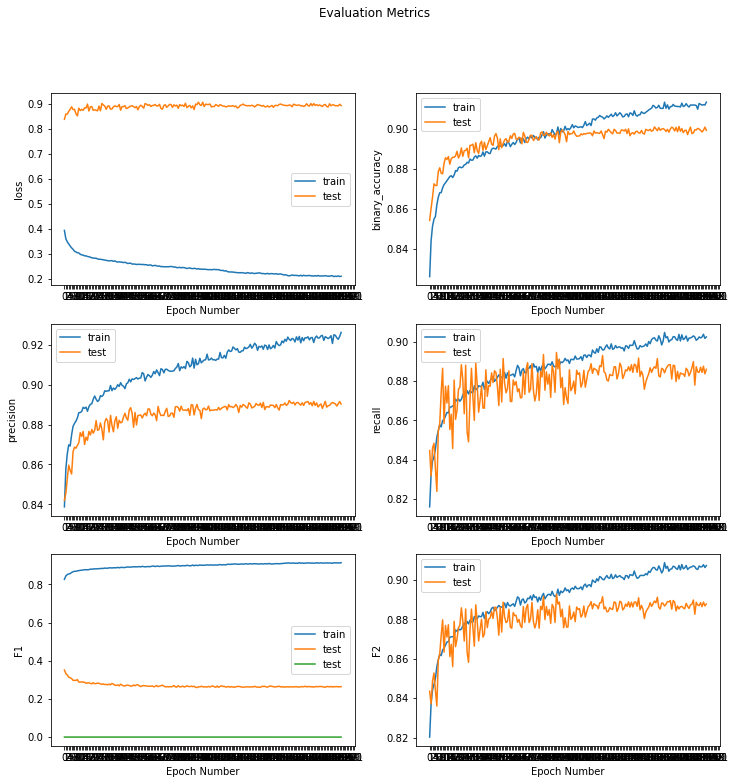

In [20]:
nn7.plot_metrics(0, 200)

In [24]:
def plot_confusion_matrix(cm, classes, normalize = False):
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title('Confusion Matrix', size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

    
def plot_roc_curve(y, prob):
    base_fpr, base_tpr, _ = mtr.roc_curve(y, [1 for _ in range(len(y))])
    model_fpr, model_tpr, _ = mtr.roc_curve(y, prob)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'rf')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

    
def train_test_measure(y_test, y_pred, y_pred_proba):
    cm = mtr.confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, ['0 - Normal', '1 - Ponzi'])

    specificity = cm[0][0] / (cm[0][0] + cm[0][1])
    recall = mtr.recall_score(y_test, y_pred)
    results = (mtr.precision_recall_fscore_support(y_test, y_pred,beta = 2))
    print('accuracy:', mtr.accuracy_score(y_test, y_pred))
#    print('precision:', mtr.precision_score(yte,y_test_pred))
#    print('recall:', recall)
    print('specificity:', specificity)
    print('precision non-fraud :', results[0][0], 'precision fraud :', results[0][1])
    print('recall non-fraud:', results[1][0], "recall fraud", results[1][1])
    print('f2 non-fraud', results[2][0], "f2 fraud : ", results[2][1] )
    print('f1:',  mtr.f1_score(y_test, y_pred))
    print('g mean: ', (recall*specificity)**0.5)
    print('auc:', mtr.roc_auc_score(y_test, y_pred_proba))
    plot_roc_curve(y_test, y_pred_proba)

accuracy: 0.9034
specificity: 0.9064444444444445
precision non-fraud : 0.9850277710697899 precision fraud : 0.509895227008149
recall non-fraud: 0.9064444444444445 recall fraud 0.876
f2 non-fraud 0.9211417731809765 f2 fraud :  0.7660020986358868
f1: 0.6445916114790287
g mean:  0.8910922137092958
auc: 0.959135111111111


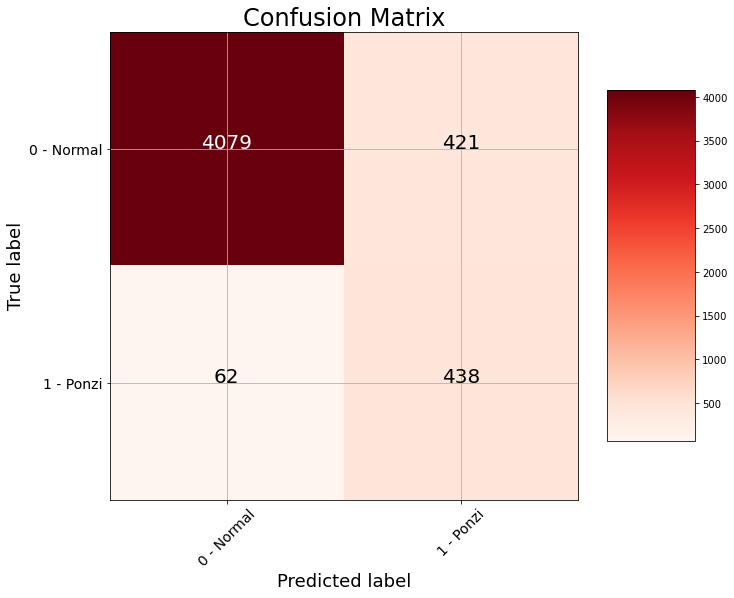

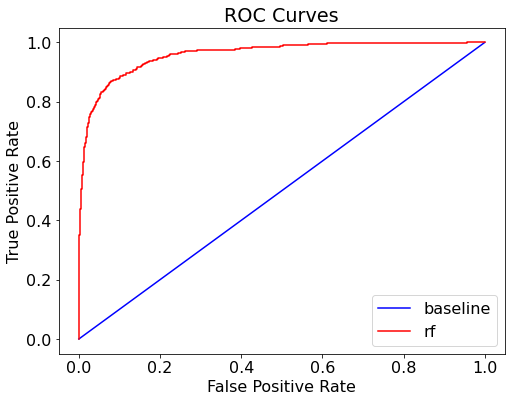

In [27]:
# Summary Performance
y_pred_proba = nn7.m.predict(x_test)
y_pred = np.array([1 if y > 0.5 else 0 for y in y_pred_proba])
train_test_measure(y_test, y_pred, y_pred_proba)